In [1]:
import sys
import torch

seed = 42
#torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree 
import fiora.visualization.spectrum_visualizer as sv

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


[15:50:17] WARNING: not removing hydrogen atom without neighbors
[15:50:17] WARNING: not removing hydrogen atom without neighbors
[15:50:17] WARNING: not removing hydrogen atom without neighbors


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


## Data

In [2]:
from typing import Literal
lib: Literal["NIST", "MSDIAL", "NIST/MSDIAL"] = "NIST/MSDIAL"
print(f"Preparing {lib} library")

test_run = False # Default: False
if test_run:
    print("+++ This is a test run with a small subset of data points. Results are not representative. +++")

Preparing NIST/MSDIAL library


In [3]:
# key map to read metadata from pandas DataFrame
metadata_key_map = {
                "name": "Name",
                "collision_energy":  "CE", 
                "instrument": "Instrument_type",
                "ionization": "Ionization",
                "precursor_mz": "PrecursorMZ",
                "precursor_mode": "Precursor_type",
                "retention_time": "RETENTIONTIME",
                "ccs": "CCS"
                }


#
# Load specified libraries and align metadata
#

def load_training_data():
    L = LibraryLoader()
    df = L.load_from_csv(f"{home}/data/metabolites/preprocessed/datasplits_Jan24.csv")
    return df

df = load_training_data()

# Restore dictionary values
dict_columns = ["peaks", "summary"]
for col in dict_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    #df[col] = df[col].apply(ast.literal_eval)
    
df['group_id'] = df['group_id'].astype(int)


In [4]:
#
# TODO: ATTENTION
#

df["ppm_peak_tolerance"] = 100 * PPM


In [5]:
%%capture
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder


CE_upper_limit = 100.0
weight_upper_limit = 1000.0


if test_run:
    df = df.iloc[:10000,:]
    #df = df.iloc[5000:20000,:]


df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df.apply(lambda x: x["Metabolite"].set_id(x["group_id"]) , axis=1)

#df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
df["num_per_group"] = df["group_id"].map(df["group_id"].value_counts())
df["loss_weight"] = 1.0 / df["num_per_group"]
df.apply(lambda x: x["Metabolite"].set_loss_weight(x["loss_weight"]), axis=1)

In [6]:
%%capture
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)

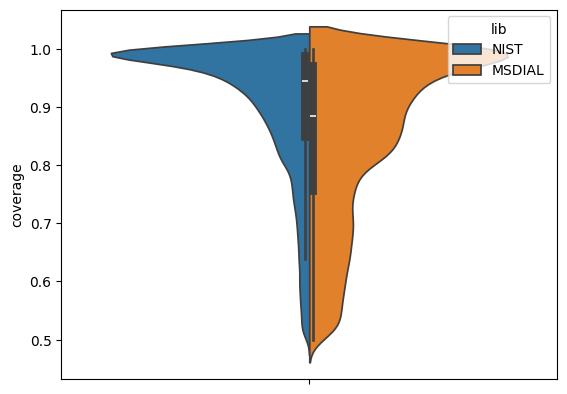

In [7]:
#
# TODO: ATTENTION
#


df["coverage"] = df["Metabolite"].apply(lambda x: x.match_stats["coverage"])

import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(df, y="coverage", hue="lib", split=True)
plt.show()

In [8]:
df.lib.value_counts()

lib
NIST      54814
MSDIAL    19587
Name: count, dtype: int64

In [9]:
df = df[df["coverage"] > 0.5] #TODO: ATTENTION 50 ppm + 50% cov cutoff

In [10]:
df.lib.value_counts()

lib
NIST      54814
MSDIAL    19583
Name: count, dtype: int64

##### Load Casmi data

In [11]:
casmi16_path = f"{home}/data/metabolites/CASMI_2016/casmi16_withCCS.csv"
casmi22_path = f"{home}/data/metabolites/CASMI_2022/casmi22_withCCS.csv"

df_cas = pd.read_csv(casmi16_path, index_col=[0], low_memory=False)
df_cas22 = pd.read_csv(casmi22_path, index_col=[0], low_memory=False)

# Restore dictionary values
dict_columns = ["peaks", "Candidates"]
for col in dict_columns:
    df_cas[col] = df_cas[col].apply(ast.literal_eval)

df_cas22["peaks"] = df_cas22["peaks"].apply(ast.literal_eval)

In [12]:
%%capture
from fiora.MOL.collision_energy import NCE_to_eV

df_cas["RETENTIONTIME"] = df_cas["RTINSECONDS"] / 60.0
df_cas["Metabolite"] = df_cas["SMILES"].apply(Metabolite)
df_cas["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas["CE"] = 20.0 # actually stepped 20/35/50
df_cas["Instrument_type"] = "HCD" # CHECK if correct Orbitrap

metadata_key_map16 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "PRECURSOR_MZ",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "RETENTIONTIME"
                 }

df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder), axis=1)

# Fragmentation
df_cas["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead

#
# CASMI 22
#

df_cas22["Metabolite"] = df_cas22["SMILES"].apply(Metabolite)
df_cas22["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

df_cas22["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df_cas22["CE"] = df_cas22.apply(lambda x: NCE_to_eV(x["NCE"], x["precursor_mz"]), axis=1)

metadata_key_map22 = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "precursor_mz": "precursor_mz",
                 'precursor_mode': "Precursor_type",
                 "retention_time": "ChallengeRT"
                 }

df_cas22["summary"] = df_cas22.apply(lambda x: {key: x[name] for key, name in metadata_key_map22.items()}, axis=1)
df_cas22.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

# Fragmentation
df_cas22["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df_cas22.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 * PPM), axis=1) # Optional: use mz_cut instead

df_cas22 = df_cas22.reset_index()

## Model Training and Testing

In [13]:
from fiora.GNN.Trainer import Trainer
import torch_geometric as geom

if torch.cuda.is_available(): 
 torch.cuda.empty_cache()
 dev = "cuda:1"
else: 
 dev = "cpu" 
 
print(f"Running on device: {dev}")




Running on device: cuda:1


##### Load Data

In [14]:
print(df.groupby("dataset")["group_id"].unique().apply(len))

df_test = df[df["dataset"] == "test"]
df_train = df[df["dataset"].isin(["training", "validation"])]

dataset
test          1070
training      8552
validation    1070
Name: group_id, dtype: int64


In [15]:
geo_data = df_train["Metabolite"].apply(lambda x: x.as_geometric_data().to(dev)).values
print(f"Prepared training/validation with {len(geo_data)} data points")

Prepared training/validation with 66960 data points


##### Prepare Model

In [16]:
model_params = {
    'param_tag': 'default',
    'gnn_type': 'RGCNConv',
    'depth': 5,
    'hidden_dimension': 300,
    'dense_layers': 2,
    'embedding_aggregation': 'concat',
    'embedding_dimension': 300,
    'input_dropout': 0.2,
    'latent_dropout': 0.1,
    'node_feature_layout': node_encoder.feature_numbers,
    'edge_feature_layout': bond_encoder.feature_numbers,    
    'static_feature_dimension': geo_data[0]["static_edge_features"].shape[1],
    'static_rt_feature_dimension': geo_data[0]["static_rt_features"].shape[1],
    'output_dimension': len(DEFAULT_MODES) * 2, # per edge 
}
training_params = {
    'epochs': 200 if not test_run else 10, 
    'batch_size': 256, #128,
    #'train_val_split': 0.90,
    'learning_rate': 0.0004,#0.001,
    'with_RT': False,
    'with_CCS': False
}

In [17]:

fixed_params = {"gnn_type": "RGCNConv"} # Mainly used for clarity
grid_params = [{'depth': 0}, {'depth': 1}, {'depth': 2}, {'depth': 3}, {'depth': 4}, {'depth': 5}, {'depth': 6}, {'depth': 7}, {'depth': 8}]#,{'depth': 0}, {'depth': 1}, {'depth': 7}, {'depth': 8}]
for p in grid_params:
    p.update(fixed_params)
#grid_params = [{'gnn_type': "GraphConv"}, {'gnn_type': "RGCNConv"}, {'gnn_type': "GAT"}, {'gnn_type': "TransformerConv"}]
#grid_params = [{'embedding_dimension': 300}, {'embedding_dimension': 400}, {'embedding_dimension': 500}]

##### Begin Training

In [18]:
from fiora.GNN.GNNModules import GNNCompiler
from fiora.GNN.Losses import WeightedMSELoss, WeightedMSEMetric
from fiora.MS.SimulationFramework import SimulationFramework

fiora = SimulationFramework(None, dev=dev, with_RT=training_params["with_RT"], with_CCS=training_params["with_CCS"])
np.seterr(invalid='ignore')
val_interval = 1
tag = "grid"
val_interval = 1
metric_dict= {"mse": WeightedMSEMetric}
loss_fn = WeightedMSELoss()

def train_new_model():
    model = GNNCompiler(model_params).to(dev)
    
    y_label = 'compiled_probsALL'
    train_keys, val_keys = df_train[df_train["dataset"] == "training"]["group_id"].unique(), df_train[df_train["dataset"] == "validation"]["group_id"].unique()
    trainer = Trainer(geo_data, y_tag=y_label, problem_type="regression", train_keys=train_keys, val_keys=val_keys, metric_dict=metric_dict, split_by_group=True, seed=seed, device=dev)
    optimizer = torch.optim.Adam(model.parameters(), lr=training_params["learning_rate"])
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( # TODO doesn't work with onlyTraining
                        optimizer,
                        patience = 8, # 10 default
                        #factor   = self.hparams['factor'],
                        mode     = 'min',
                        verbose  = True)
    
    
    # from accelerate import notebook_launcher
    # args = {"model": model, "optimizer": optimizer, "loss_fn": loss_fn, "scheduler": scheduler, "batch_size": training_params['batch_size'], "epochs": training_params["epochs"], "val_every_n_epochs": val_interval, "with_RT": True, "masked_validation": training_params["with_RT"], "mask_name": "compiled_validation_maskALL"}
    # notebook_launcher(trainer.train, args,  num_processes=4)
    checkpoints = trainer.train(model, optimizer, loss_fn, scheduler=scheduler, batch_size=training_params['batch_size'], epochs=training_params["epochs"], val_every_n_epochs=val_interval, with_CCS=training_params["with_CCS"],  with_RT=training_params["with_RT"], masked_validation=False, tag=tag) #, mask_name="compiled_validation_maskALL")
    print(checkpoints)
    return model, checkpoints



def simulate_all(model, DF):
    return fiora.simulate_all(DF, model)

    
def test_model(model, DF):
    dft = simulate_all(model, DF)
    
    return dft["spectral_sqrt_cosine"].values

##### Test CASMI 16 and 22

In [19]:
from fiora.MOL.collision_energy import NCE_to_eV
from fiora.MS.spectral_scores import spectral_cosine, spectral_reflection_cosine, reweighted_dot
from fiora.MS.ms_utility import merge_annotated_spectrum

def test_cas16(model, df_cas=df_cas):
    
    df_cas["NCE"] = 20.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step1_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_20")

    df_cas["NCE"] = 35.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step2_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_35")


    df_cas["NCE"] = 50.0 # actually stepped NCE 20/35/50
    df_cas["CE"] = df_cas[["NCE", "PRECURSOR_MZ"]].apply(lambda x: NCE_to_eV(x["NCE"], x["PRECURSOR_MZ"]), axis=1)
    df_cas["step3_CE"] = df_cas["CE"]
    df_cas["summary"] = df_cas.apply(lambda x: {key: x[name] for key, name in metadata_key_map16.items()}, axis=1)
    df_cas.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)
    df_cas = fiora.simulate_all(df_cas, model, suffix="_50")

    df_cas["avg_CE"] = (df_cas["step1_CE"] + df_cas["step2_CE"] + df_cas["step3_CE"]) / 3

    df_cas["merged_peaks"] = df_cas.apply(lambda x: merge_annotated_spectrum(merge_annotated_spectrum(x["sim_peaks_20"], x["sim_peaks_35"]), x["sim_peaks_50"]) , axis=1)
    df_cas["merged_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["merged_sqrt_cosine"] = df_cas.apply(lambda x: spectral_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_refl_cosine"] = df_cas.apply(lambda x: spectral_reflection_cosine(x["peaks"], x["merged_peaks"], transform=np.sqrt), axis=1)
    df_cas["merged_steins"] = df_cas.apply(lambda x: reweighted_dot(x["peaks"], x["merged_peaks"]), axis=1)
    df_cas["spectral_sqrt_cosine"] = df_cas["merged_sqrt_cosine"] # just remember it is merged

    df_cas["coverage"] = df_cas["Metabolite"].apply(lambda x: x.match_stats["coverage"])
    df_cas["RT_pred"] = df_cas["RT_pred_35"]
    df_cas["RT_dif"] = df_cas["RT_dif_35"]
    df_cas["CCS_pred"] = df_cas["CCS_pred_35"]
    df_cas["library"] = "CASMI-16"
    
    return df_cas["merged_sqrt_cosine"].values

In [20]:
results = []
results_cp = []

for params in grid_params:
    print(f"Testing {params}")
    model_params.update(params)
    current_model, checkpoint = train_new_model()
    val_results = test_model(current_model, df_train[df_train["dataset"]== "validation"])
    test_results = test_model(current_model, df_test)
    casmi16_results = test_cas16(current_model)
    casmi16_p = test_cas16(current_model, df_cas[df_cas["Precursor_type"] == "[M+H]+"])
    casmi16_n = test_cas16(current_model, df_cas[df_cas["Precursor_type"] == "[M-H]-"])
    casmi22_results = test_model(current_model, df_cas22)
    casmi22_p = test_model(current_model, df_cas22[df_cas22["Precursor_type"] == "[M+H]+"])
    casmi22_n = test_model(current_model, df_cas22[df_cas22["Precursor_type"] == "[M-H]-"])
    
    results.append({**params, "model": copy.deepcopy(current_model), "cp": checkpoint, "validation": val_results, "test": test_results, "casmi16": casmi16_results, "casmi22": casmi22_results, "casmi16+": casmi16_p, "casmi16-": casmi16_n, "casmi22+": casmi22_p, "casmi22-": casmi22_n})
    
    current_model = current_model.load(checkpoint["file"])
    val_results_cp = test_model(current_model, df_train[df_train["dataset"]== "validation"])
    test_results_cp = test_model(current_model, df_test)
    casmi16_results_cp = test_cas16(current_model)
    casmi16_p_cp = test_cas16(current_model, df_cas[df_cas["Precursor_type"] == "[M+H]+"])
    casmi16_n_cp = test_cas16(current_model, df_cas[df_cas["Precursor_type"] == "[M-H]-"])
    casmi22_results_cp = test_model(current_model, df_cas22)
    casmi22_p_cp = test_model(current_model, df_cas22[df_cas22["Precursor_type"] == "[M+H]+"])
    casmi22_n_cp = test_model(current_model, df_cas22[df_cas22["Precursor_type"] == "[M-H]-"])
    results_cp.append({**params, "model": copy.deepcopy(current_model), "cp": checkpoint, "validation": val_results_cp, "test": test_results_cp, "casmi16": casmi16_results_cp, "casmi22": casmi22_results_cp, "casmi16+": casmi16_p_cp, "casmi16-": casmi16_n_cp, "casmi22+": casmi22_p_cp, "casmi22-": casmi22_n_cp})
    
    

Testing {'depth': 0, 'gnn_type': 'RGCNConv'}
Using pre-arranged train/validation set
	Validation RMSE: 0.015656
	Validation RMSE: 0.015350
	Validation RMSE: 0.014947
	Validation RMSE: 0.014645
	Validation RMSE: 0.014543
	Validation RMSE: 0.014742
	Validation RMSE: 0.014441
	Validation RMSE: 0.014841
	Validation RMSE: 0.014740
	Validation RMSE: 0.0144140
	Validation RMSE: 0.0144139
	Validation RMSE: 0.0143139
	Validation RMSE: 0.0144139
	Validation RMSE: 0.0143139
	Validation RMSE: 0.0142139
	Validation RMSE: 0.0142138
	Validation RMSE: 0.0142138
	Validation RMSE: 0.0143138
	Validation RMSE: 0.0143138
	Validation RMSE: 0.0142138
	Validation RMSE: 0.0142138
	Validation RMSE: 0.0142138
	Validation RMSE: 0.0143138
	Validation RMSE: 0.0143137
	Validation RMSE: 0.0143137
	Validation RMSE: 0.0143137
	Validation RMSE: 0.0142137
	Validation RMSE: 0.0141137
	Validation RMSE: 0.0142137
	Validation RMSE: 0.0142137
	Validation RMSE: 0.0140137
	Validation RMSE: 0.0144137
	Validation RMSE: 0.0141136


/home/ynowatzk/repos/fiora/fiora/MS/SimulationFramework.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(columns=[x + suffix for x in ["cosine_similarity", "kl_div", "sim_peaks", "spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_sqrt_bias_wo_prec", "spectral_refl_bias", "steins_cosine", "steins_bias", "RT_pred", "RT_dif", "CCS_pred"]])])
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divid

Testing {'depth': 1, 'gnn_type': 'RGCNConv'}
Using pre-arranged train/validation set
	Validation RMSE: 0.015354
	Validation RMSE: 0.014845
	Validation RMSE: 0.014041
	Validation RMSE: 0.014037
	Validation RMSE: 0.013735
	Validation RMSE: 0.013533
	Validation RMSE: 0.013632
	Validation RMSE: 0.013231
	Validation RMSE: 0.013330
	Validation RMSE: 0.0131129
	Validation RMSE: 0.0132128
	Validation RMSE: 0.0132128
	Validation RMSE: 0.0132127
	Validation RMSE: 0.0131127
	Validation RMSE: 0.0131126
	Validation RMSE: 0.0131125
	Validation RMSE: 0.0129125
	Validation RMSE: 0.0131124
	Validation RMSE: 0.0131124
	Validation RMSE: 0.0128123
	Validation RMSE: 0.0131123
	Validation RMSE: 0.0128123
	Validation RMSE: 0.0128122
	Validation RMSE: 0.0129121
	Validation RMSE: 0.0129121
	Validation RMSE: 0.0128121
	Validation RMSE: 0.0128120
	Validation RMSE: 0.0128120
	Validation RMSE: 0.0128120
	Validation RMSE: 0.0129119
	Validation RMSE: 0.0127119
	Validation RMSE: 0.0127119
	Validation RMSE: 0.0127118


/home/ynowatzk/repos/fiora/fiora/MS/SimulationFramework.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(columns=[x + suffix for x in ["cosine_similarity", "kl_div", "sim_peaks", "spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_sqrt_bias_wo_prec", "spectral_refl_bias", "steins_cosine", "steins_bias", "RT_pred", "RT_dif", "CCS_pred"]])])
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divid

Testing {'depth': 2, 'gnn_type': 'RGCNConv'}
Using pre-arranged train/validation set
	Validation RMSE: 0.014953
	Validation RMSE: 0.014944
	Validation RMSE: 0.014139
	Validation RMSE: 0.013835
	Validation RMSE: 0.013531
	Validation RMSE: 0.013330
	Validation RMSE: 0.013328
	Validation RMSE: 0.012926
	Validation RMSE: 0.012925
	Validation RMSE: 0.0130124
	Validation RMSE: 0.0131123
	Validation RMSE: 0.0129123
	Validation RMSE: 0.0130121
	Validation RMSE: 0.0127121
	Validation RMSE: 0.0127120
	Validation RMSE: 0.0127119
	Validation RMSE: 0.0126118
	Validation RMSE: 0.0125118
	Validation RMSE: 0.0125117
	Validation RMSE: 0.0125116
	Validation RMSE: 0.0124116
	Validation RMSE: 0.0125115
	Validation RMSE: 0.0124115
	Validation RMSE: 0.0124113
	Validation RMSE: 0.0124113
	Validation RMSE: 0.0124112
	Validation RMSE: 0.0124112
	Validation RMSE: 0.0124112
	Validation RMSE: 0.0125111
	Validation RMSE: 0.0123110
	Validation RMSE: 0.0123110
	Validation RMSE: 0.0123109
	Validation RMSE: 0.0123109


/home/ynowatzk/repos/fiora/fiora/MS/SimulationFramework.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(columns=[x + suffix for x in ["cosine_similarity", "kl_div", "sim_peaks", "spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_sqrt_bias_wo_prec", "spectral_refl_bias", "steins_cosine", "steins_bias", "RT_pred", "RT_dif", "CCS_pred"]])])
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divid

Testing {'depth': 3, 'gnn_type': 'RGCNConv'}
Using pre-arranged train/validation set
	Validation RMSE: 0.015054
	Validation RMSE: 0.014545
	Validation RMSE: 0.013839
	Validation RMSE: 0.013833
	Validation RMSE: 0.013330
	Validation RMSE: 0.013228
	Validation RMSE: 0.012926
	Validation RMSE: 0.013024
	Validation RMSE: 0.013023
	Validation RMSE: 0.0127122
	Validation RMSE: 0.0128120
	Validation RMSE: 0.0128119
	Validation RMSE: 0.0126118
	Validation RMSE: 0.0126117
	Validation RMSE: 0.0126116
	Validation RMSE: 0.0126114
	Validation RMSE: 0.0126114
	Validation RMSE: 0.0124113
	Validation RMSE: 0.0125112
	Validation RMSE: 0.0124111
	Validation RMSE: 0.0124110
	Validation RMSE: 0.0125109
	Validation RMSE: 0.0124109
	Validation RMSE: 0.0124108
	Validation RMSE: 0.0124107
	Validation RMSE: 0.0123106
	Validation RMSE: 0.0123105
	Validation RMSE: 0.0122105
	Validation RMSE: 0.0122104
	Validation RMSE: 0.0121104
	Validation RMSE: 0.0123103
	Validation RMSE: 0.0122103
	Validation RMSE: 0.0123102


/home/ynowatzk/repos/fiora/fiora/MS/SimulationFramework.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(columns=[x + suffix for x in ["cosine_similarity", "kl_div", "sim_peaks", "spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_sqrt_bias_wo_prec", "spectral_refl_bias", "steins_cosine", "steins_bias", "RT_pred", "RT_dif", "CCS_pred"]])])
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = vec_other / np.linalg.norm(vec_other)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divid

Testing {'depth': 4, 'gnn_type': 'RGCNConv'}
Using pre-arranged train/validation set
	Validation RMSE: 0.015256
	Validation RMSE: 0.014844
	Validation RMSE: 0.014738
	Validation RMSE: 0.013533
	Validation RMSE: 0.013229
	Validation RMSE: 0.013027
	Validation RMSE: 0.012924
	Validation RMSE: 0.012823
	Validation RMSE: 0.012721
	Validation RMSE: 0.0128119
	Validation RMSE: 0.0129118
	Validation RMSE: 0.0127116
	Validation RMSE: 0.0127115
	Validation RMSE: 0.0125114
	Validation RMSE: 0.0125112
	Validation RMSE: 0.0126111
	Validation RMSE: 0.0125110
	Validation RMSE: 0.0125109
	Validation RMSE: 0.0123108
	Validation RMSE: 0.0124108
	Validation RMSE: 0.0123106
	Validation RMSE: 0.0123105
	Validation RMSE: 0.0122104
	Validation RMSE: 0.0124104
	Validation RMSE: 0.0121102
	Validation RMSE: 0.0125101
	Validation RMSE: 0.0122101
	Validation RMSE: 0.0122101
	Validation RMSE: 0.0120100
	Validation RMSE: 0.0121099
	Validation RMSE: 0.0121098
	Validation RMSE: 0.0121097
	Validation RMSE: 0.0121097


/home/ynowatzk/repos/fiora/fiora/MS/SimulationFramework.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(columns=[x + suffix for x in ["cosine_similarity", "kl_div", "sim_peaks", "spectral_cosine", "spectral_sqrt_cosine", "spectral_sqrt_cosine_wo_prec", "spectral_refl_cosine", "spectral_bias", "spectral_sqrt_bias", "spectral_sqrt_bias_wo_prec", "spectral_refl_bias", "steins_cosine", "steins_bias", "RT_pred", "RT_dif", "CCS_pred"]])])
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:26: RuntimeWarning: divide by zero encountered in divide
  vec = vec / np.linalg.norm(vec)
/home/ynowatzk/repos/fiora/fiora/MS/spectral_scores.py:27: RuntimeWarning: divide by zero encountered in divide
  vec_other = ve

Testing {'depth': 5, 'gnn_type': 'RGCNConv'}
Using pre-arranged train/validation set
	Validation RMSE: 0.014853
	Validation RMSE: 0.014543
	Validation RMSE: 0.013938
	Validation RMSE: 0.013732
	Validation RMSE: 0.013229
	Validation RMSE: 0.013226
	Validation RMSE: 0.013023
	Validation RMSE: 0.012921
	Validation RMSE: 0.012719
	Validation RMSE: 0.0128118
	Validation RMSE: 0.0126116
	Validation RMSE: 0.0125115
	Validation RMSE: 0.0126114
	Validation RMSE: 0.0127112
	Validation RMSE: 0.0126111
	Validation RMSE: 0.0123109
	Validation RMSE: 0.0124108
	Validation RMSE: 0.0126107
	Validation RMSE: 0.0126106
	Validation RMSE: 0.0123105
	Validation RMSE: 0.0124104
	Validation RMSE: 0.0123103
	Validation RMSE: 0.0124102
	Validation RMSE: 0.0124101
	Validation RMSE: 0.0121100
	Validation RMSE: 0.0123100
	Validation RMSE: 0.0121098
	Validation RMSE: 0.0121098


In [ ]:
np.median(val_results)


0.8156011121422528

In [ ]:
LOG = pd.DataFrame(results)
eval_columns = LOG.columns[4:]

home_path = f"{home}/data/metabolites/benchmarking/"
NAME = model_params["gnn_type"] + "_Jan24_test.csv"
for col in eval_columns:
    LOG[col] = LOG[col].apply(lambda x: str(list(x)))
LOG.to_csv(home_path + NAME, index=False, sep="\t")

In [ ]:
LOG = pd.DataFrame(results)
eval_columns = LOG.columns[4:]
LOG[eval_columns].apply(lambda x: x.apply(np.median))

,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
0,0.623900,0.643749,0.562569,0.190330,0.547106,0.600550,0.185881,0.201172
1,0.748864,0.758750,0.677116,0.222095,0.639818,0.716146,0.218479,0.241026
2,0.774824,0.787598,0.672370,0.233795,0.651114,0.698537,0.224006,0.244148
3,0.786212,0.808357,0.707807,0.241470,0.698671,0.727066,0.232242,0.266062
4,0.797457,0.816196,0.691875,0.262217,0.686376,0.696978,0.248958,0.273634
5,0.815345,0.829066,0.695731,0.252801,0.677156,0.720680,0.244204,0.264334
6,0.811614,0.826783,0.715087,0.248433,0.706270,0.740173,0.241472,0.252556
7,0.814916,0.824113,0.702562,0.247649,0.682535,0.725958,0.242773,0.251557
8,0.815601,0.829062,0.713091,0.261253,0.673204,0.762918,0.251056,0.288130


In [ ]:
results[2]["cp"]

{'epoch': 76,
 'val_loss': 6.995545118115842e-05,
 'file': '../../checkpoint_grid.best.pt'}

In [ ]:
LOG = pd.DataFrame(results_cp)
eval_columns = LOG.columns[4:]
LOG[eval_columns].apply(lambda x: x.apply(np.median))

,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
0,0.624652,0.641330,0.562113,0.190855,0.537592,0.604846,0.187096,0.200407
1,0.749376,0.757511,0.676740,0.222336,0.642249,0.726392,0.217513,0.239777
2,0.774437,0.787305,0.672654,0.233817,0.650499,0.701651,0.225958,0.245596
3,0.785397,0.806419,0.708888,0.244843,0.706854,0.740035,0.235642,0.271536
4,0.797393,0.815910,0.693507,0.261852,0.685024,0.703494,0.248736,0.272997
5,0.814625,0.828507,0.695647,0.251926,0.679962,0.721397,0.245457,0.263191
6,0.810178,0.826095,0.709052,0.251723,0.704214,0.732377,0.249558,0.253325
7,0.812917,0.820377,0.706327,0.246431,0.691698,0.731480,0.246634,0.242534
8,0.813335,0.827644,0.709213,0.262659,0.675115,0.763608,0.251025,0.290209


In [ ]:
LOG = pd.DataFrame(results_cp)
eval_columns = LOG.columns[4:]

home_path = f"{home}/data/metabolites/benchmarking/"
NAME = model_params["gnn_type"] + "_cp_Jan24_test.csv"
for col in eval_columns:
    LOG[col] = LOG[col].apply(lambda x: str(list(x)))
LOG.to_csv(home_path + NAME, index=False, sep="\t")

In [ ]:
LOGIC = pd.read_csv(home_path + NAME, sep="\t")
for col in eval_columns:
    LOGIC[col] = LOGIC[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
#LOGIC[eval_columns].apply(lambda x: x.apply(np.median))

In [ ]:
LOGIC[eval_columns] = LOGIC[eval_columns].apply(lambda x: x.apply(np.median))
LOGIC


,depth,gnn_type,model,cp,validation,test,casmi16,casmi22,casmi16+,casmi16-,casmi22+,casmi22-
0,0,RGCNConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 96, 'val_loss': 9.810260962694883e-0...",0.624652,0.641330,0.562113,0.190855,0.537592,0.604846,0.187096,0.200407
1,1,RGCNConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 83, 'val_loss': 7.599949458381161e-0...",0.749376,0.757511,0.676740,0.222336,0.642249,0.726392,0.217513,0.239777
2,2,RGCNConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 76, 'val_loss': 6.995545118115842e-0...",0.774437,0.787305,0.672654,0.233817,0.650499,0.701651,0.225958,0.245596
3,3,RGCNConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 67, 'val_loss': 6.861641304567456e-0...",0.785397,0.806419,0.708888,0.244843,0.706854,0.740035,0.235642,0.271536
4,4,RGCNConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 78, 'val_loss': 6.645594112342224e-0...",0.797393,0.815910,0.693507,0.261852,0.685024,0.703494,0.248736,0.272997
5,5,RGCNConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 104, 'val_loss': 6.563819624716416e-...",0.814625,0.828507,0.695647,0.251926,0.679962,0.721397,0.245457,0.263191
6,6,RGCNConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 73, 'val_loss': 6.65279949316755e-05...",0.810178,0.826095,0.709052,0.251723,0.704214,0.732377,0.249558,0.253325
7,7,RGCNConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 60, 'val_loss': 6.651994772255421e-0...",0.812917,0.820377,0.706327,0.246431,0.691698,0.731480,0.246634,0.242534
8,8,RGCNConv,GNNCompiler(\n (node_embedding): FeatureEmbed...,"{'epoch': 94, 'val_loss': 6.534979183925316e-0...",0.813335,0.827644,0.709213,0.262659,0.675115,0.763608,0.251025,0.290209
